ROI Analysis

In [8]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [9]:
# Helper Functions
def partial_eta_squared(aov):
    """Calculate partial eta-squared for ANOVA results."""
    aov = aov.copy()
    aov['pes'] = (aov['Num DF'] * aov['F Value']) / (aov['Num DF'] * aov['F Value'] + aov['Den DF'])
    return aov

def analyze_roi_data(data, experiment='exp1'):
    """Analyze ROI data with multiple comparison correction."""
    results = {}
    all_tests = []
    
    if experiment == 'exp1':
        conditions = ['object', 'scramble']
        rois = ['LO', 'pIPS']
    else:
        conditions = ['tool', 'nontool']
        rois = ['PFS', 'aIPS', 'LO', 'pIPS']
        
    for roi in rois:
        for hemi in ['left', 'right']:
            roi_data = data[(data['roi'] == roi) & (data['hemi'] == hemi)]
            cond1_data = roi_data[roi_data['cond'] == conditions[0]]['mean_act'].values
            cond2_data = roi_data[roi_data['cond'] == conditions[1]]['mean_act'].values
            
            # Calculate statistics
            t_stat, p_val = ttest_rel(cond1_data, cond2_data)
            mean_diff = np.mean(cond1_data - cond2_data)
            se_diff = np.std(cond1_data - cond2_data) / np.sqrt(len(cond1_data))
            d = mean_diff / np.sqrt((np.std(cond1_data)**2 + np.std(cond2_data)**2) / 2)
            
            # Store results
            all_tests.append({
                'roi': f'{hemi}_{roi}',
                'p_value': p_val,
                't_stat': t_stat,
                'mean_diff': mean_diff,
                'se': se_diff,
                'cohens_d': d,
                'n': len(cond1_data),
                f'mean_{conditions[0]}': np.mean(cond1_data),
                f'mean_{conditions[1]}': np.mean(cond2_data)
            })
    
    # Apply Holm-Bonferroni correction
    p_values = [test['p_value'] for test in all_tests]
    _, p_corrected, _, _ = multipletests(p_values, method='holm')
    
    # Update results with corrected p-values
    for test, p_corr in zip(all_tests, p_corrected):
        results[test['roi']] = test
        results[test['roi']]['p_corrected'] = p_corr
    
    return results

def run_rmanova(data, factors):
    """Run repeated measures ANOVA with effect sizes."""
    aov = AnovaRM(data=data, 
                  depvar='mean_act',
                  subject='sub',
                  within=factors).fit()
    
    aov_table = partial_eta_squared(aov.anova_table)
    return aov_table

In [10]:
# Load Data
# Experiment 1
exp1_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/selectivity/selectivity_summary.csv")

filtered_exp1 = exp1_results[(exp1_results['group'] == 'control') & 
                            (exp1_results['roi'].isin(['LO', 'pIPS'])) &
                            (exp1_results['sub'] != 'sub-084')]

# Experiment 2
exp2_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/tools/selectivity/selectivity_summarytoolloc.csv")
filtered_exp2 = exp2_results[exp2_results['sub'].str.contains('spaceloc')]

In [11]:
# Experiment 1 ROI Analysis
# Full ANOVA
exp1_anova = run_rmanova(filtered_exp1, ['roi', 'hemi', 'cond'])
print("Experiment 1 ANOVA Results:")
print(exp1_anova)

# ROI Analysis
exp1_roi_results = analyze_roi_data(filtered_exp1, 'exp1')
print("\nExperiment 1 ROI Results:")
for roi, stats in exp1_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")

Experiment 1 ANOVA Results:
                  F Value  Num DF  Den DF        Pr > F       pes
roi             39.763898     1.0    17.0  7.897722e-06  0.700514
hemi            10.301246     1.0    17.0  5.140748e-03  0.377318
cond            55.387486     1.0    17.0  9.623988e-07  0.765153
roi:hemi         2.803147     1.0    17.0  1.123766e-01  0.141551
roi:cond       108.745714     1.0    17.0  8.346158e-09  0.864807
hemi:cond        2.746805     1.0    17.0  1.157867e-01  0.139101
roi:hemi:cond    0.056390     1.0    17.0  8.151334e-01  0.003306


NameError: name 'ttest_rel' is not defined

In [12]:
# Experiment 2 ROI Analysis
# Full ANOVA
exp2_anova = run_rmanova(filtered_exp2, ['roi', 'hemi', 'cond'])
print("Experiment 2 ANOVA Results:")
print(exp2_anova)

# ROI Analysis
exp2_roi_results = analyze_roi_data(filtered_exp2, 'exp2')
print("\nExperiment 2 ROI Results:")
for roi, stats in exp2_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")



Experiment 2 ANOVA Results:
                 F Value  Num DF  Den DF        Pr > F       pes
roi            69.788835     3.0    51.0  4.595074e-18  0.804122
hemi           25.586962     1.0    17.0  9.700100e-05  0.600817
cond            1.697378     1.0    17.0  2.100038e-01  0.090782
roi:hemi        1.617712     3.0    51.0  1.967325e-01  0.086891
roi:cond       23.018004     3.0    51.0  1.468259e-09  0.575191
hemi:cond      15.531839     1.0    17.0  1.053597e-03  0.477435
roi:hemi:cond   1.616753     3.0    51.0  1.969531e-01  0.086844


NameError: name 'ttest_rel' is not defined

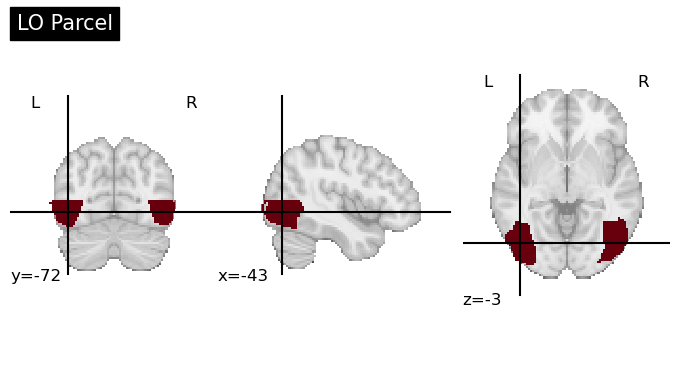

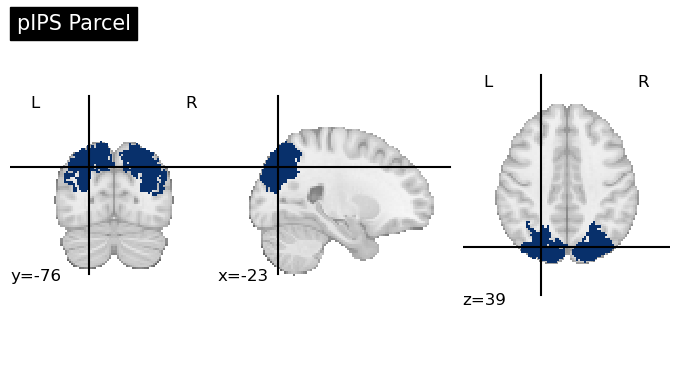

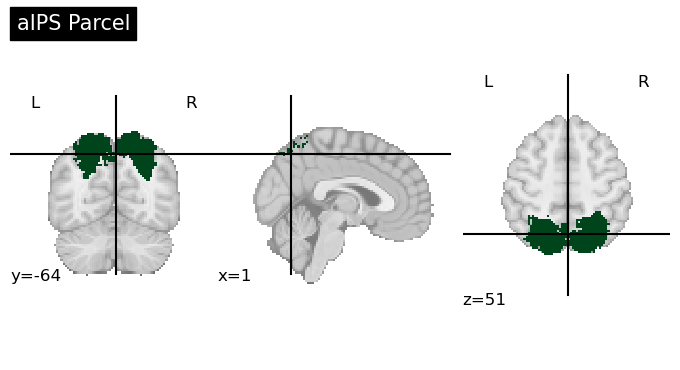

In [2]:
# explaining roi creation
from nilearn import plotting, datasets
import nibabel as nib

# Load each parcel
parcel_lo = nib.load('roiParcels/LO.nii.gz')
parcel_pips = nib.load('roiParcels/pIPS.nii.gz')
parcel_aips = nib.load('roiParcels/aIPS.nii.gz')

# Plot each Julian/Mruczek parcel with colors
plotting.plot_stat_map(parcel_lo, title="LO Parcel", colorbar=False, cmap='Reds', threshold=0.1)
plotting.plot_stat_map(parcel_pips, title="pIPS Parcel", colorbar=False, cmap='Blues', threshold=0.1)
plotting.plot_stat_map(parcel_aips, title="aIPS Parcel", colorbar=False, cmap='Greens', threshold=0.1)

plotting.show()

FC and PPI Connectivity Analysis

In [13]:
# FC Analysis (Experiment 1)
import os
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load data
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# Compare hemispheric patterns

# Ispilateral vs Contralateral
diff = ipsi.values - contra.values  # Convert to numpy arrays for element-wise subtraction
std_diff = np.std(diff, ddof=1) # Check for variance in differences
if std_diff == 0:  # Handle case where standard deviation is zero
    print("Standard deviation of differences is zero, preventing computation of Cohen's d.")
    d_ipsi = "NaN (variance is zero)"
else:
    # Compute Cohen's d for paired data
    d_ipsi = np.mean(diff) / std_diff

# Left vs Right pIPS seeds
left_pips = fc_data[fc_data['seed_hemisphere'] == 'left']['mean_activation']
right_pips = fc_data[fc_data['seed_hemisphere'] == 'right']['mean_activation']
w_stat_seed, p_val_seed = stats.wilcoxon(left_pips, right_pips)
# Independent effect size (Cohen's d for unpaired data)
d_seed = (np.mean(left_pips) - np.mean(right_pips)) / (
    np.sqrt((np.var(left_pips, ddof=1) + np.var(right_pips, ddof=1)) / 2) + 1e-10
)

# Left vs Right LO targets
left_lo = fc_data[fc_data['target_hemisphere'] == 'left']['mean_activation']
right_lo = fc_data[fc_data['target_hemisphere'] == 'right']['mean_activation']
w_stat_target, p_val_target = stats.wilcoxon(left_lo, right_lo)
# Independent effect size (Cohen's d for unpaired data)
d_target = (np.mean(left_lo) - np.mean(right_lo)) / (
    np.sqrt((np.var(left_lo, ddof=1) + np.var(right_lo, ddof=1)) / 2) + 1e-10
)

# Perform FDR correction for multiple comparisons
p_values = [p_val_ipsi, p_val_seed, p_val_target]
_, p_values_corrected = fdrcorrection(p_values)

# Print results
print("\nHemispheric Connectivity Comparisons:")

print(f"Ipsilateral vs Contralateral:")
print(f"W = {w_stat_ipsi}, p = {p_val_ipsi:.3f}, d = {d_ipsi}")

print(f"\nLeft vs Right pIPS seeds:")
print(f"W = {w_stat_seed}, p = {p_val_seed:.3f} (FDR-corrected p = {p_values_corrected[1]:.3f}), d = {d_seed:.3f}")
print(f"Mean Left = {np.mean(left_pips):.3f} ± {stats.sem(left_pips):.3f}")
print(f"Mean Right = {np.mean(right_pips):.3f} ± {stats.sem(right_pips):.3f}")

print(f"\nLeft vs Right LO targets:")
print(f"W = {w_stat_target}, p = {p_val_target:.3f} (FDR-corrected p = {p_values_corrected[2]:.3f}), d = {d_target:.3f}")
print(f"Mean Left = {np.mean(left_lo):.3f} ± {stats.sem(left_lo):.3f}")
print(f"Mean Right = {np.mean(right_lo):.3f} ± {stats.sem(right_lo):.3f}")


NameError: name 'ipsi' is not defined

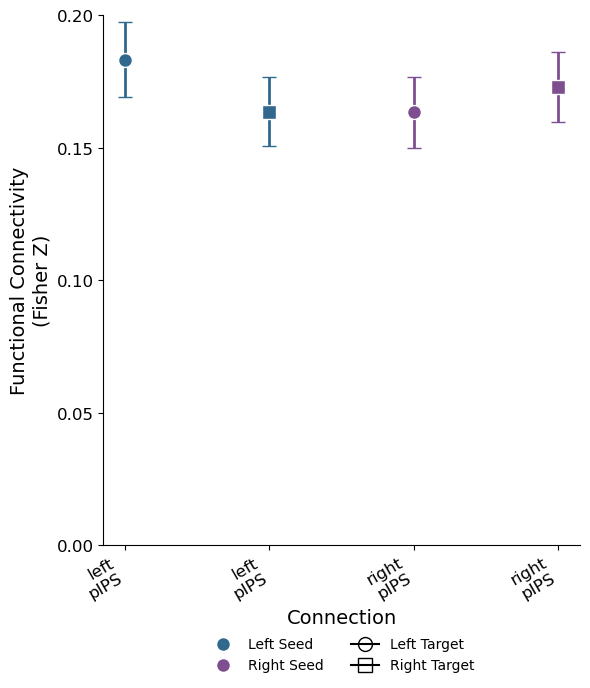

In [14]:
# plot fc data exp 1
import matplotlib.pyplot as plt
import numpy as np

def create_fc_plot(fc_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space at bottom for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = fc_data[
                (fc_data['seed_hemisphere'] == seed_hemi) &
                (fc_data['target_hemisphere'] == target_hemi)
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=5, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Functional Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    
    # Set y-axis minimum to 0 and fewer ticks
    ax.set_ylim(bottom=0, top=0.2)
    ax.set_yticks(np.arange(0, 0.21, 0.05))  # Set ticks at 0, 0.05, 0.10, 0.15, 0.20
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_fc_plot(fc_data)
plt.show()

In [19]:
# Combined PPI (Experiment 1)
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')

# Directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def calculate_effect_size(data1, data2=None):
    """Calculate effect size for one-sample or two-sample data"""
    if data2 is None:  # one-sample
        return np.mean(data1) / (np.std(data1, ddof=1) + 1e-10)
    else:  # two-sample
        diff = np.mean(data1) - np.mean(data2)
        pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
        return diff / (pooled_std + 1e-10)

def analyze_ppi_data_nonparametric(data_df):
    """Analyze PPI data using non-parametric tests"""
    results = {}
    
    # 1. Test each condition against 0 using Wilcoxon signed-rank test
    conditions = []
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            subset = data_df[
                (data_df['seed_hemisphere'] == seed_hemi) &
                (data_df['target_hemisphere'] == target_hemi)
            ]['mean_activation']
            
            w_stat, p_val = stats.wilcoxon(subset)
            d = calculate_effect_size(subset)
            
            conditions.append({
                'connection': f"{seed_hemi} pIPS - {target_hemi} LO",
                'W': w_stat,
                'p': p_val,
                'd': d,
                'mean': np.mean(subset),
                'sem': stats.sem(subset)
            })
    
    # Apply FDR correction to zero-tests
    conditions_df = pd.DataFrame(conditions)
    _, conditions_df['p_fdr'] = fdrcorrection(conditions_df['p'])
    results['conditions'] = conditions_df
    
    # 2. Friedman test for overall differences
    # Reshape data for Friedman test
    wide_data = pd.pivot_table(
        data_df,
        values='mean_activation',
        index='subject',  # Make sure your data has a subject column
        columns=['seed_hemisphere', 'target_hemisphere']
    )
    
    chi2, friedman_p = stats.friedmanchisquare(*[wide_data[col] for col in wide_data.columns])
    results['friedman'] = {
        'chi2': chi2,
        'p': friedman_p,
        'df': len(wide_data.columns) - 1
    }
    
    # 3. Post-hoc Wilcoxon signed-rank tests for hemispheric differences
    post_hoc_results = []
    
    # Seed hemisphere comparison (collapsing across target)
    left_pips = data_df[data_df['seed_hemisphere'] == 'left']['mean_activation']
    right_pips = data_df[data_df['seed_hemisphere'] == 'right']['mean_activation']
    w_stat_seed, p_val_seed = stats.wilcoxon(left_pips, right_pips)
    d_seed = calculate_effect_size(left_pips, right_pips)
    
    post_hoc_results.append({
        'comparison': 'Left pIPS vs Right pIPS',
        'W': w_stat_seed,
        'p_uncorrected': p_val_seed,
        'd': d_seed,
        'mean_diff': np.mean(left_pips) - np.mean(right_pips),
        'left_mean': np.mean(left_pips),
        'left_sem': stats.sem(left_pips),
        'right_mean': np.mean(right_pips),
        'right_sem': stats.sem(right_pips)
    })
    
    # Target hemisphere comparison (collapsing across seed)
    left_lo = data_df[data_df['target_hemisphere'] == 'left']['mean_activation']
    right_lo = data_df[data_df['target_hemisphere'] == 'right']['mean_activation']
    w_stat_target, p_val_target = stats.wilcoxon(left_lo, right_lo)
    d_target = calculate_effect_size(left_lo, right_lo)
    
    post_hoc_results.append({
        'comparison': 'Left LO vs Right LO',
        'W': w_stat_target,
        'p_uncorrected': p_val_target,
        'd': d_target,
        'mean_diff': np.mean(left_lo) - np.mean(right_lo),
        'left_mean': np.mean(left_lo),
        'left_sem': stats.sem(left_lo),
        'right_mean': np.mean(right_lo),
        'right_sem': stats.sem(right_lo)
    })
    
    # Apply FDR correction to post-hoc tests
    post_hoc_df = pd.DataFrame(post_hoc_results)
    _, post_hoc_df['p_fdr'] = fdrcorrection(post_hoc_df['p_uncorrected'])
    results['post_hoc'] = post_hoc_df
    
    return results

# Load and prepare data
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
ppi_data = data_df[data_df['analysis'] == 'ppi']

# Run analysis
results = analyze_ppi_data_nonparametric(ppi_data)

# Print results
print("\nFriedman Test Results:")
print(f"χ²({results['friedman']['df']}) = {results['friedman']['chi2']:.3f}, p = {results['friedman']['p']:.3f}")

print("\nCondition Statistics (testing against 0):")
print(results['conditions'].round(3))

print("\nPost-hoc Tests:")
print(results['post_hoc'].round(3))


Friedman Test Results:
χ²(3) = 11.905, p = 0.008

Condition Statistics (testing against 0):
              connection     W      p      d   mean    sem  p_fdr
0    left pIPS - left LO   3.0  0.000  1.305  0.035  0.006  0.000
1   left pIPS - right LO  12.0  0.000  1.125  0.031  0.006  0.000
2   right pIPS - left LO  13.0  0.000  1.107  0.028  0.006  0.000
3  right pIPS - right LO  20.0  0.001  0.977  0.023  0.005  0.001

Post-hoc Tests:
                comparison      W  p_uncorrected      d  mean_diff  left_mean  \
0  Left pIPS vs Right pIPS  183.0          0.007  0.301      0.008      0.033   
1      Left LO vs Right LO  208.0          0.018  0.177      0.005      0.031   

   left_sem  right_mean  right_sem  p_fdr  
0     0.004       0.025      0.004  0.013  
1     0.004       0.027      0.004  0.018  


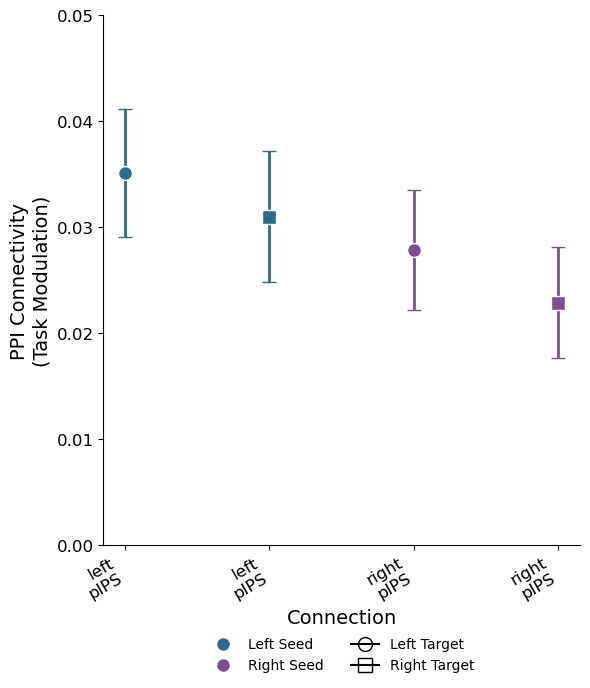

In [63]:
# Plot PPI data exp 1
import numpy as np

def create_ppi_plot(ppi_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = ppi_data[
                (ppi_data['seed_hemisphere'] == seed_hemi) &
                (ppi_data['target_hemisphere'] == target_hemi) &
                (ppi_data['analysis'] == 'ppi')
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=5, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('PPI Connectivity\n(Task Modulation)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    
    # Set y-axis scale with tighter limits
    # Add just a bit of padding above and below the data
    data_range = max(means) - min(means)
    padding = data_range * 0.1  # 10% padding
    ymin = max(-0.05, min(means) - padding)  # Don't go below -0.05 if data doesn't warrant it
    ymax = max(means) + padding
    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(np.floor(ymin*20)/20, ymax+0.02, 0.01))  # Ticks every 0.05
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_ppi_plot(data_df)
plt.show()

In [26]:
# Combined PPI (Experiment 2)
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')

# Directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
output_dir = f'{curr_dir}/tools'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def calculate_effect_size(data):
    """Calculate Cohen's d for one-sample test"""
    return np.mean(data) / (np.std(data, ddof=1) + 1e-10)

# Load data
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition labels
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'
exp2_df = pd.concat([tools_df, nontools_df])

# 1. Test each connection against zero (separately for Tools and Nontools)
def test_connections_against_zero(data, condition):
    results = []
    data_subset = data[data['condition'] == condition]
    
    for seed_roi in ['pIPS', 'aIPS']:
        for seed_hemi in ['left', 'right']:
            for target_hemi in ['left', 'right']:
                subset = data_subset[
                    (data_subset['seed_roi'] == seed_roi) &
                    (data_subset['seed_hemi'] == seed_hemi) &
                    (data_subset['target_hemi'] == target_hemi)
                ]['value']
                
                w_stat, p_val = stats.wilcoxon(subset, alternative='two-sided')
                d = calculate_effect_size(subset)
                
                results.append({
                    'connection': f"{seed_hemi} {seed_roi} - {target_hemi} LO",
                    'W': w_stat,
                    'p': p_val,
                    'd': d,
                    'mean': np.mean(subset),
                    'sem': stats.sem(subset)
                })
    
    results_df = pd.DataFrame(results)
    _, results_df['p_fdr'] = fdrcorrection(results_df['p'])
    return results_df

# Run zero tests for each condition
tools_zero_tests = test_connections_against_zero(exp2_df, 'Tools')
nontools_zero_tests = test_connections_against_zero(exp2_df, 'Nontools')

# 2. Full Friedman test across all factors
# Reshape data for Friedman test
wide_data = pd.pivot_table(
    exp2_df,
    values='value',
    index=['subject', 'condition'],
    columns=['seed_roi', 'seed_hemi', 'target_hemi']
).reset_index()

# Separate by condition for Friedman test
tools_wide = wide_data[wide_data['condition'] == 'Tools'].drop('condition', axis=1)
nontools_wide = wide_data[wide_data['condition'] == 'Nontools'].drop('condition', axis=1)

# Run Friedman test for each condition
tools_chi2, tools_p = stats.friedmanchisquare(*[tools_wide[col] for col in tools_wide.columns if col != 'subject'])
nontools_chi2, nontools_p = stats.friedmanchisquare(*[nontools_wide[col] for col in nontools_wide.columns if col != 'subject'])

# Print and save results
with open(f"{results_dir}/exp2_ppi_stats_summary.txt", 'w') as f:
    # Tools results
    print("\nTools Condition Results:")
    print(f"Friedman Test: χ²({len(tools_wide.columns)-2}) = {tools_chi2:.3f}, p = {tools_p:.3f}")
    print("\nTests against zero:")
    print(tools_zero_tests.round(3))
    
    # Nontools results
    print("\nNontools Condition Results:")
    print(f"Friedman Test: χ²({len(nontools_wide.columns)-2}) = {nontools_chi2:.3f}, p = {nontools_p:.3f}")
    print("\nTests against zero:")
    print(nontools_zero_tests.round(3))
    
    # Write to file
    f.write("\nTools Condition Results:\n")
    f.write(f"Friedman Test: χ²({len(tools_wide.columns)-2}) = {tools_chi2:.3f}, p = {tools_p:.3f}\n")
    f.write("\nTests against zero:\n")
    f.write(tools_zero_tests.round(3).to_string())
    
    f.write("\n\nNontools Condition Results:\n")
    f.write(f"Friedman Test: χ²({len(nontools_wide.columns)-2}) = {nontools_chi2:.3f}, p = {nontools_p:.3f}\n")
    f.write("\nTests against zero:\n")
    f.write(nontools_zero_tests.round(3).to_string())

# Save detailed results to CSVs
tools_zero_tests.to_csv(f"{results_dir}/exp2_tools_zero_tests.csv", index=False)
nontools_zero_tests.to_csv(f"{results_dir}/exp2_nontools_zero_tests.csv", index=False)

ValueError: could not convert string to float: 'sub-spaceloc1001'

GCA

In [ ]:
# exp 1 GCA
# nonparametric gca univariate analysis
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

# Read the existing summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Apply FDR correction to the Wilcoxon p-values
p_values = summary_table_combined['p_value'].values
rejected, p_corrected = fdrcorrection(p_values, alpha=0.05, method='indep')

# Update table with FDR results
summary_table_combined['p_value_fdr'] = p_corrected
summary_table_combined['significant_fdr'] = rejected

# Save updated results
summary_table_combined.to_csv(f"{fig_dir}/gca_summary_table_combined_fdr.csv", index=False)

# Simple Cohen's d calculation
def calculate_cohens_d(mean_diff, std_diff):
    """Calculate Cohen's d as simple standardized mean difference"""
    return abs(mean_diff / std_diff)

print("\nCohen's d calculations:")
for _, row in summary_table_combined.iterrows():
    d = calculate_cohens_d(row['Mean f_diff'], row['Std f_diff'])
    print(f"{row['origin']}-{row['target']} ({row['condition']}): d = {d:.2f}")

# Update and display results
print("\nAfter FDR correction:")
print(summary_table_combined)

# Extract comparison p-values from the summary table
object_lpips_llo = summary_table_combined[(summary_table_combined['condition'] == 'Object') & 
                                        (summary_table_combined['origin'] == 'lpIPS') & 
                                        (summary_table_combined['target'] == 'lLO')]['p_value_fdr'].values[0]

object_lpips_rlo = summary_table_combined[(summary_table_combined['condition'] == 'Object') & 
                                        (summary_table_combined['origin'] == 'lpIPS') & 
                                        (summary_table_combined['target'] == 'rLO')]['p_value_fdr'].values[0]

scramble_lpips_llo = summary_table_combined[(summary_table_combined['condition'] == 'Scramble') & 
                                          (summary_table_combined['origin'] == 'lpIPS') & 
                                          (summary_table_combined['target'] == 'lLO')]['p_value_fdr'].values[0]

scramble_lpips_rlo = summary_table_combined[(summary_table_combined['condition'] == 'Scramble') & 
                                          (summary_table_combined['origin'] == 'lpIPS') & 
                                          (summary_table_combined['target'] == 'rLO')]['p_value_fdr'].values[0]

# Save FDR-corrected Wilcoxon test results
with open(f"{fig_dir}/gca_roi_pair_combined_comparison_results_fdr.txt", 'w') as f:
    f.write("GCA ROI Pair Combined Comparison Results (Wilcoxon tests):\n\n")
    f.write("Object Condition:\n")
    f.write("lpIPS-lLO vs rpIPS-lLO:\n")
    f.write(f"p_fdr = {object_lpips_llo:.4f}\n")
    f.write("lpIPS-rLO vs rpIPS-rLO:\n")
    f.write(f"p_fdr = {object_lpips_rlo:.4f}\n")
    f.write("\nScramble Condition:\n")
    f.write("lpIPS-lLO vs rpIPS-lLO:\n")
    f.write(f"p_fdr = {scramble_lpips_llo:.4f}\n")
    f.write("lpIPS-rLO vs rpIPS-rLO:\n")
    f.write(f"p_fdr = {scramble_lpips_rlo:.4f}\n")


Cohen's d calculations:
lpIPS-lLO (Object): d = 0.66
lpIPS-rLO (Object): d = 0.83
rpIPS-lLO (Object): d = 0.22
rpIPS-rLO (Object): d = 0.17
lpIPS-lLO (Scramble): d = 0.28
lpIPS-rLO (Scramble): d = 0.13
rpIPS-lLO (Scramble): d = 0.12
rpIPS-rLO (Scramble): d = 0.19

After FDR correction:
  origin target condition  Mean f_diff  Std f_diff  W_statistic  p_value  \
0  lpIPS    lLO    Object         7.71       11.70         21.0  0.00169   
1  lpIPS    rLO    Object         7.49        9.01         10.0  0.00016   
2  rpIPS    lLO    Object         1.82        8.12         61.0  0.18187   
3  rpIPS    rLO    Object         1.58        9.33         66.0  0.25793   
4  lpIPS    lLO  Scramble         1.05        3.73         71.0  0.35246   
5  lpIPS    rLO  Scramble         0.82        6.17         65.0  0.24125   
6  rpIPS    lLO  Scramble         0.63        5.05         89.0  0.82878   
7  rpIPS    rLO  Scramble         0.79        4.10         79.0  0.54122   

   Effect size  significant

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri

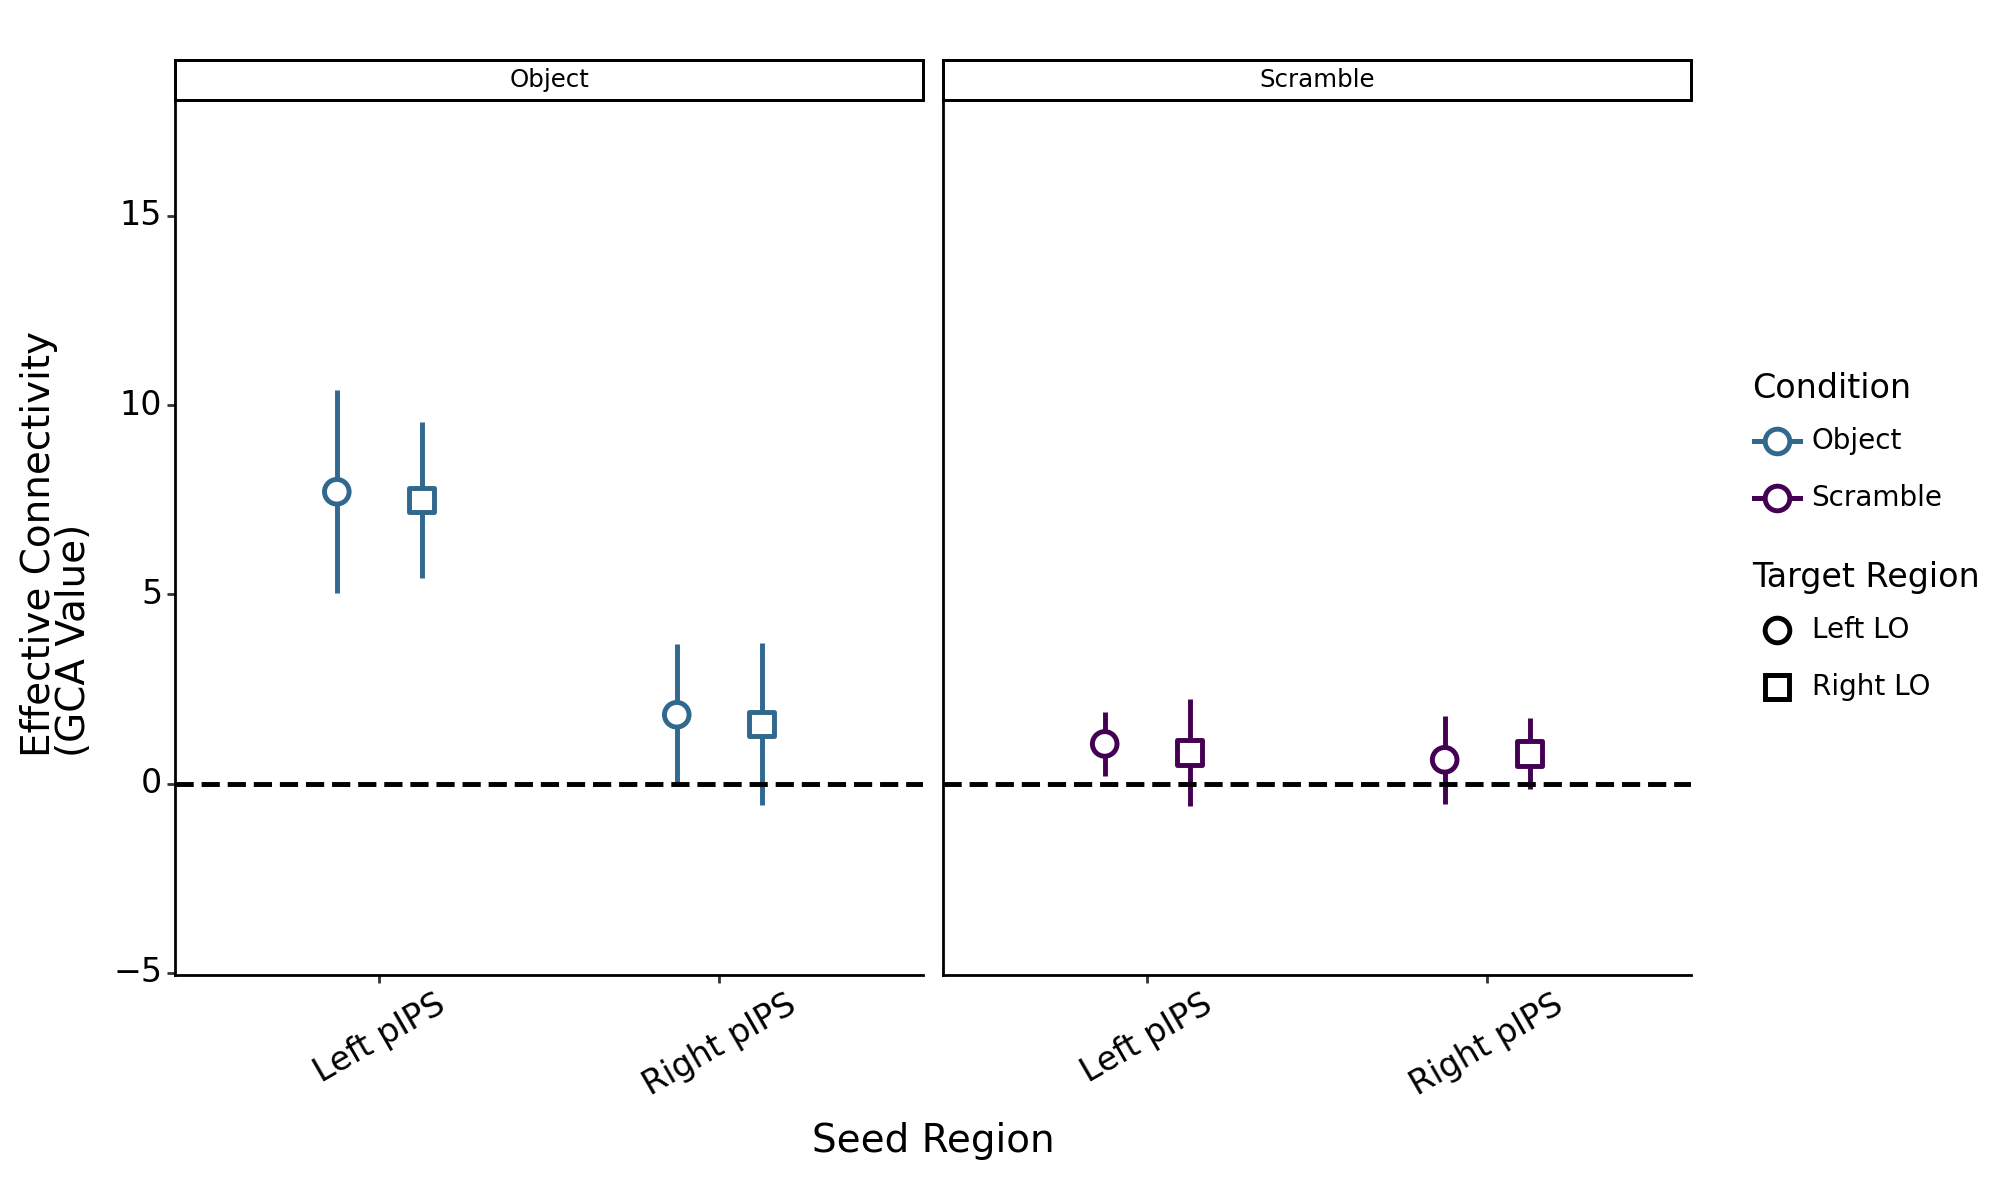

In [9]:
# exp 1 GCA plot
# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                    ylim, xlab, ylab, theme, element_text, element_line, 
                    element_blank, scale_color_manual, position_dodge2, 
                    geom_hline, scale_shape_manual, labs, facet_wrap)

# Read the summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Create a plotting dataframe
plot_df = pd.DataFrame({
   'ROI': ['Left pIPS' if 'lpIPS' in x else 'Right pIPS' for x in summary_table_combined['origin']],
   'COND': ['Left LO' if 'lLO' in x else 'Right LO' for x in summary_table_combined['target']],
   'condition': summary_table_combined['condition'],
   'GC': summary_table_combined['Mean f_diff'],
   'SE': summary_table_combined['Std f_diff']/np.sqrt(19)  # Using n=19 subjects
})

# Make categorical variables
plot_df['ROI'] = pd.Categorical(plot_df['ROI'], categories=['Left pIPS', 'Right pIPS'], ordered=False)
plot_df['COND'] = pd.Categorical(plot_df['COND'], categories=['Left LO', 'Right LO'], ordered=False)
plot_df['condition'] = pd.Categorical(plot_df['condition'], categories=['Object', 'Scramble'], ordered=False)

# Create the plot
plot = (ggplot(plot_df, aes(x='ROI', y='GC', color='condition', shape='COND'))
       + geom_linerange(aes(ymin='GC - SE', ymax='GC + SE'), 
                       size=1, position=position_dodge2(width=0.5))
       + geom_point(size=4, fill='white', stroke=1, 
                   position=position_dodge2(width=0.5))
       + ylim(-4, 17)
       + scale_color_manual(values=['#31688E', '#440154'])
       + scale_shape_manual(values=['o', 's'])
       + theme_classic()
       + labs(color='Condition', shape='Target Region')
       + xlab('Seed Region')
       + ylab('Effective Connectivity \n(GCA Value)')
       + geom_hline(yintercept=0, linetype='dashed', size=1)
       + theme(
           text=element_text(color='black'),
           axis_text_x=element_text(angle=30, size=12),
           axis_text_y=element_text(size=12),
           axis_title=element_text(size=14),
           axis_line=element_line(),
           panel_border=element_blank(),
           legend_position="right",
           legend_box="vertical",
           legend_title=element_text(size=12),
           legend_text=element_text(size=10),
           figure_size=(10, 6)
       )
       + facet_wrap('~ condition'))

print(plot)

Calculating global scale...
Global value range: -16.13 to 18.42
Using scale: -18.42 to 18.42
Using threshold: 4.00


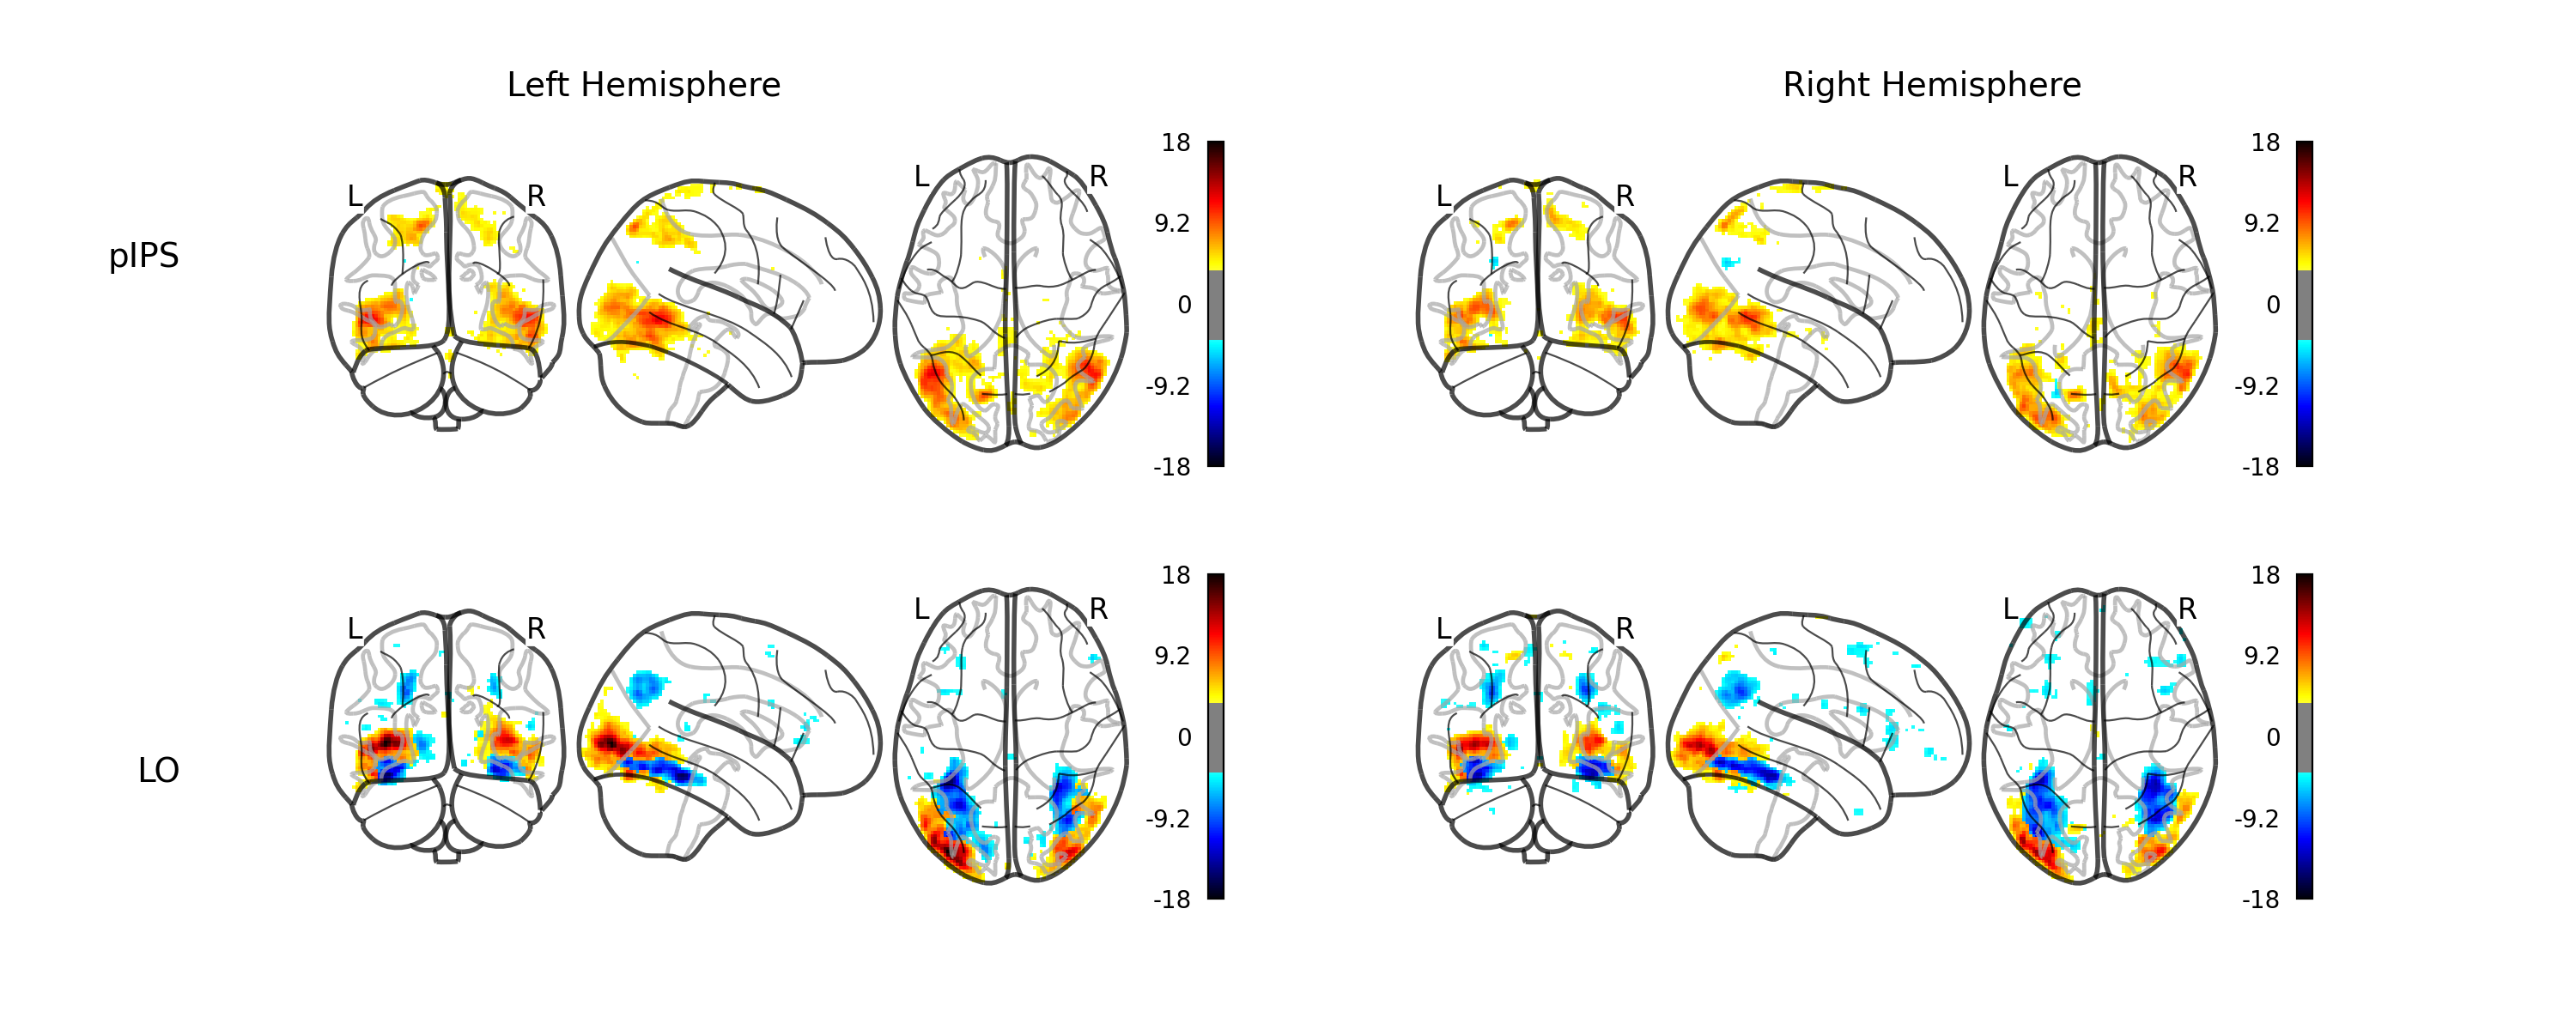


Processing complete.


In [25]:
# GCA Searchlight FIGURE
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import glob
import os
import re

def load_and_average(file_pattern):
    """Helper function to load and average files"""
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None, []
    
    # Extract and sort subject numbers
    subject_files = {}
    for f in files:
        match = re.search(r'sub-(\d+)', f)
        if match:
            subject_files[match.group(1)] = f
    
    sorted_subjects = sorted(subject_files.keys(), key=int)
    
    # Load all images
    images = [nib.load(subject_files[subject]) for subject in sorted_subjects]
    
    # Check if all images have the same shape
    shapes = [img.shape for img in images]
    if len(set(shapes)) > 1:
        print("Error: Not all images have the same shape.")
        return None, None, []
    
    # Calculate the average
    avg_data = np.mean([img.get_fdata() for img in images], axis=0)
    avg_img = nib.Nifti1Image(avg_data, images[0].affine, images[0].header)
    
    return avg_data, avg_img, sorted_subjects

def find_global_scale(base_path, regions):
    """Find global min and max values across all group averages"""
    all_averages = []
    
    for region in regions:
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, _, _ = load_and_average(file_pattern)
        if avg_data is not None:
            all_averages.append(avg_data)
    
    if all_averages:
        global_min = min(np.min(avg) for avg in all_averages)
        global_max = max(np.max(avg) for avg in all_averages)
        return global_min, global_max
    return None, None

def create_2x2_brain_figure(base_path, regions, vmin, vmax, threshold):
    # Create figure with adjusted height
    fig = plt.figure(figsize=(15, 6))  # Reduced height
    
    # Add column labels (hemisphere labels)
    fig.text(0.25, 0.9, 'Left Hemisphere', ha='center', va='bottom', fontsize=14)
    fig.text(0.75, 0.9, 'Right Hemisphere', ha='center', va='bottom', fontsize=14)
    
    # Add row labels
    fig.text(0.07, 0.75, 'pIPS', ha='right', va='center', fontsize=14)
    fig.text(0.07, 0.25, 'LO', ha='right', va='center', fontsize=14)
    
    # Define the order for 2x2 layout
    region_order = ['pIPS_left', 'pIPS_right', 'LO_left', 'LO_right']
    
    for idx, region in enumerate(region_order):
        # Calculate subplot position (2x2 grid)
        ax = plt.subplot(2, 2, idx + 1)
        
        # Load and average data
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, avg_img, _ = load_and_average(file_pattern)
        
        if avg_img is None:
            continue
        
        # Save the average image
        output_path = f'group_average_{region}.nii.gz'
        nib.save(avg_img, output_path)
        
        # Display the brain with specific display settings
        display = plotting.plot_glass_brain(
            avg_img,
            threshold=threshold,
            colorbar=True,
            plot_abs=False,
            vmin=vmin,
            vmax=vmax,
            display_mode='ortho',
            axes=ax,
            black_bg=False,
            title=''  # Remove individual titles since we have row/column labels
        )

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.3, top=0.9, bottom=0.1, left=0.1, right=0.9)
    
    plt.savefig('combined_brain_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

# Base path
base_path = '/lab_data/behrmannlab/vlad/ptoc'

# First find global min and max
print("Calculating global scale...")
regions = ['pIPS_right', 'pIPS_left', 'LO_right', 'LO_left']
global_min, global_max = find_global_scale(base_path, regions)
print(f"Global value range: {global_min:.2f} to {global_max:.2f}")

# Set symmetric limits based on the absolute maximum value
sym_max = max(abs(global_min), abs(global_max))
vmin, vmax = -sym_max, sym_max
##to manually set the scales uncomment the following line
#vmin, vmax = -25, 25

# Set threshold
threshold = 4

print(f"Using scale: {vmin:.2f} to {vmax:.2f}")
print(f"Using threshold: {threshold:.2f}")

# Create the combined figure
create_2x2_brain_figure(base_path, regions, vmin=vmin, vmax=vmax, threshold=threshold)

print("\nProcessing complete.")

Calculating global scale...


Global value range: -16.13 to 18.42
Using scale: -18.42 to 18.42
Using threshold: 4.00


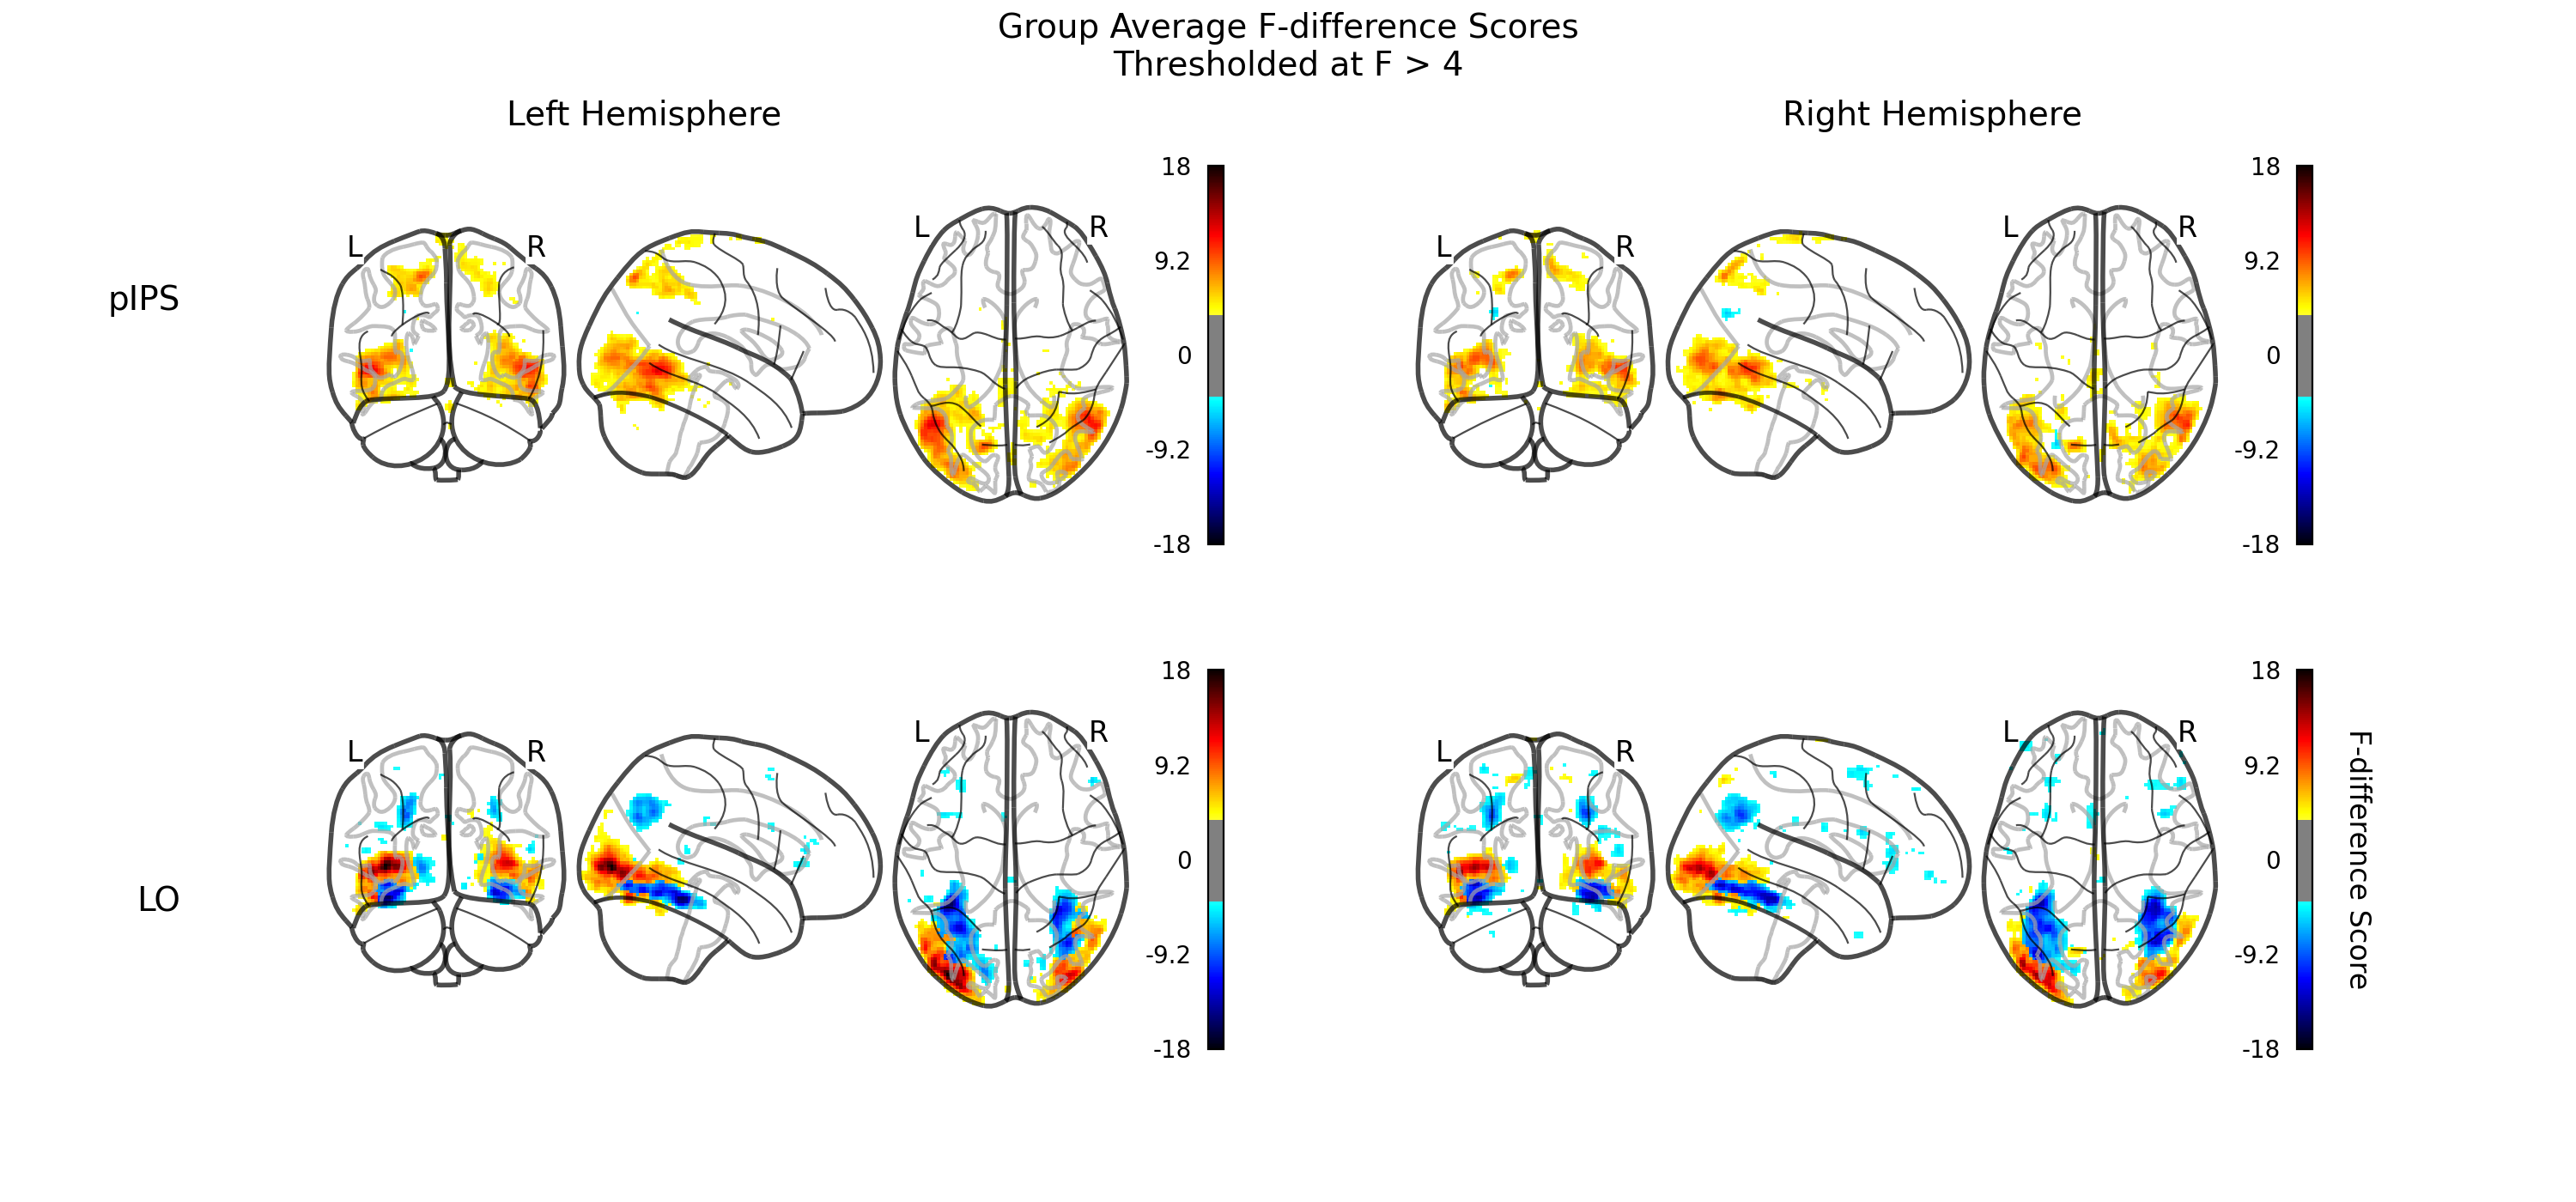


Processing complete.


In [31]:
# GCA Searchlight FIGURE
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import glob
import os
import re

def load_and_average(file_pattern):
    """Helper function to load and average files"""
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None, []
    
    # Extract and sort subject numbers
    subject_files = {}
    for f in files:
        match = re.search(r'sub-(\d+)', f)
        if match:
            subject_files[match.group(1)] = f
    
    sorted_subjects = sorted(subject_files.keys(), key=int)
    
    # Load all images
    images = [nib.load(subject_files[subject]) for subject in sorted_subjects]
    
    # Check if all images have the same shape
    shapes = [img.shape for img in images]
    if len(set(shapes)) > 1:
        print("Error: Not all images have the same shape.")
        return None, None, []
    
    # Calculate the average
    avg_data = np.mean([img.get_fdata() for img in images], axis=0)
    avg_img = nib.Nifti1Image(avg_data, images[0].affine, images[0].header)
    
    return avg_data, avg_img, sorted_subjects

def find_global_scale(base_path, regions):
    """Find global min and max values across all group averages"""
    all_averages = []
    
    for region in regions:
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, _, _ = load_and_average(file_pattern)
        if avg_data is not None:
            all_averages.append(avg_data)
    
    if all_averages:
        global_min = min(np.min(avg) for avg in all_averages)
        global_max = max(np.max(avg) for avg in all_averages)
        return global_min, global_max
    return None, None

def create_2x2_brain_figure(base_path, regions, vmin, vmax, threshold):
    # Create figure with adjusted height
    fig = plt.figure(figsize=(15, 7))  # Slightly increased height for colorbar label
    
    # Add column labels (hemisphere labels)
    fig.text(0.25, 0.89, 'Left Hemisphere', ha='center', va='bottom', fontsize=14)
    fig.text(0.75, 0.89, 'Right Hemisphere', ha='center', va='bottom', fontsize=14)
    
    # Add row labels
    fig.text(0.07, 0.75, 'pIPS', ha='right', va='center', fontsize=14)
    fig.text(0.07, 0.25, 'LO', ha='right', va='center', fontsize=14)
    
    # Define the order for 2x2 layout
    region_order = ['pIPS_left', 'pIPS_right', 'LO_left', 'LO_right']
    
    # Create a list to store display objects
    displays = []
    
    for idx, region in enumerate(region_order):
        # Calculate subplot position (2x2 grid)
        ax = plt.subplot(2, 2, idx + 1)
        
        # Load and average data
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, avg_img, _ = load_and_average(file_pattern)
        
        if avg_img is None:
            continue
        
        # Save the average image
        output_path = f'group_average_{region}.nii.gz'
        nib.save(avg_img, output_path)
        
        # Display the brain with specific display settings
        display = plotting.plot_glass_brain(
            avg_img,
            threshold=threshold,
            colorbar=True,
            plot_abs=False,
            vmin=vmin,
            vmax=vmax,
            display_mode='ortho',
            axes=ax,
            black_bg=False,
            title=''  # Remove individual titles since we have row/column labels
        )
        displays.append(display)
    
    # Add colorbar label to the last display
    if displays:
        # Get the last colorbar axes
        last_display = displays[-1]
        if hasattr(last_display, '_cbar'):
            cbar = last_display._cbar
            # Update colorbar label
            cbar.set_label('F-difference Score', rotation=270, labelpad=25, fontsize=12)
    
    # Add a title for the entire figure
    fig.suptitle('Group Average F-difference Scores\nThresholded at F > {}'.format(threshold), 
                 y=.99, fontsize=14)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.3, top=0.9, bottom=0.1, left=0.1, right=0.9)
    
    plt.savefig('combined_brain_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

# Base path
base_path = '/lab_data/behrmannlab/vlad/ptoc'

# First find global min and max
print("Calculating global scale...")
regions = ['pIPS_right', 'pIPS_left', 'LO_right', 'LO_left']
global_min, global_max = find_global_scale(base_path, regions)
print(f"Global value range: {global_min:.2f} to {global_max:.2f}")

# Set symmetric limits based on the absolute maximum value
sym_max = max(abs(global_min), abs(global_max))
vmin, vmax = -sym_max, sym_max
##to manually set the scales uncomment the following line
#vmin, vmax = -25, 25

# Set threshold
threshold = 4

print(f"Using scale: {vmin:.2f} to {vmax:.2f}")
print(f"Using threshold: {threshold:.2f}")

# Create the combined figure
create_2x2_brain_figure(base_path, regions, vmin=vmin, vmax=vmax, threshold=threshold)

print("\nProcessing complete.")